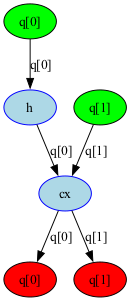

<Figure size 800x600 with 0 Axes>

In [ ]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
import matplotlib.pyplot as plt
from qiskit.dagcircuit.dagnode import DAGOpNode, DAGInNode, DAGOutNode
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGOpNode
from qiskit.circuit.library import XGate, HGate, ZGate
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

import numpy as np

from optimizers import XHXtoHZReduction, HXHtoZReduction, RemoveConsecutiveH, MergeConsecutiveRX, TCountTemplateReduction, ToffoliTCountReduction
from helpers import grover_oracle

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

dag = circuit_to_dag(qc)

fig = plt.figure(figsize=(8, 6))
dag.draw()

### Remove of consecutive H gates

Original circuit:


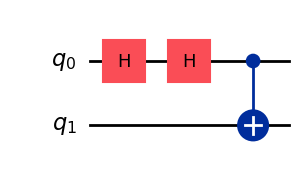

In [50]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(0) 
qc.cx(0, 1)

pass_manager = PassManager([RemoveConsecutiveH()])
optimized_circuit = pass_manager.run(qc)

print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Optimized circuit:


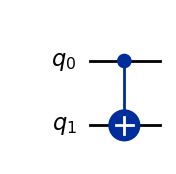

In [51]:
print("\nOptimized circuit:")
optimized_circuit.draw(output="mpl", style="iqp")

### Merge consecutive RX

Original circuit:


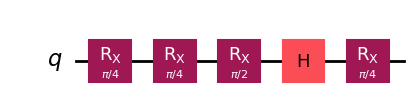

In [53]:
qc = QuantumCircuit(1)
qc.rx(np.pi/4, 0)
qc.rx(np.pi/4, 0)
qc.rx(np.pi/2, 0)
qc.h(0)
qc.rx(np.pi/4, 0)

print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Optimized circuit:


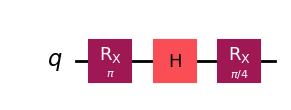

In [54]:
pass_manager = PassManager([MergeConsecutiveRX()])
optimized_circuit = pass_manager.run(qc)

print("\nOptimized circuit:")
optimized_circuit.draw(output="mpl", style="iqp")

### CX-T pattern

Original circuit:


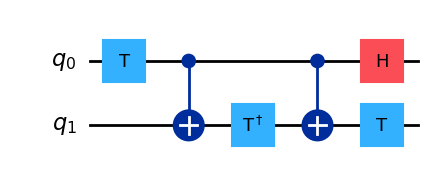

In [55]:
qc = QuantumCircuit(2)
qc.t(0)
qc.cx(0, 1)
qc.tdg(1)
qc.cx(0, 1)
qc.h(0)
qc.t(1)

print("Original circuit:")
qc.draw(output="mpl", style="iqp")


Optimized circuit:


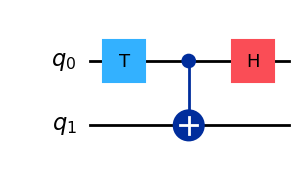

In [56]:
pass_manager = PassManager([TCountTemplateReduction()])
optimized_circuit = pass_manager.run(qc)

print("\nOptimized circuit:")
optimized_circuit.draw(output="mpl", style="iqp")


In [32]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.measure_all()

dag = circuit_to_dag(qc)

# Create and run the pass
pass_manager = PassManager([ToffoliTCountReduction()])
optimized_circuit = pass_manager.run(qc)

print("Original circuit:")
print(qc)
print("\nOptimized circuit:")
print(optimized_circuit)

Original circuit:
              ░ ┌─┐      
   q_0: ──■───░─┤M├──────
          │   ░ └╥┘┌─┐   
   q_1: ──■───░──╫─┤M├───
        ┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 

Optimized circuit:
              ░ ┌─┐      
   q_0: ──■───░─┤M├──────
          │   ░ └╥┘┌─┐   
   q_1: ──■───░──╫─┤M├───
        ┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 


## Gate optimizations 

In [57]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap

cmap = CouplingMap([[0, 1], [1, 2]])

grover = QuantumCircuit(3, 3)
grover.h([0, 1, 2])
grover.cz(0, 2)  
grover.h([0, 1, 2])
grover.measure([0, 1, 2], [0, 1, 2])

print("Original Grover circuit:")
print(grover.draw())

grover_routed = transpile(grover, coupling_map=cmap, optimization_level=0)

print("\nGrover circuit routed for linear coupling map (with SWAPs):")
grover_routed.draw()

Original Grover circuit:
     ┌───┐   ┌───┐   ┌─┐   
q_0: ┤ H ├─■─┤ H ├───┤M├───
     ├───┤ │ ├───┤┌─┐└╥┘   
q_1: ┤ H ├─┼─┤ H ├┤M├─╫────
     ├───┤ │ ├───┤└╥┘ ║ ┌─┐
q_2: ┤ H ├─■─┤ H ├─╫──╫─┤M├
     └───┘   └───┘ ║  ║ └╥┘
c: 3/══════════════╩══╩══╩═
                   1  0  2 

Grover circuit routed for linear coupling map (with SWAPs):


┌───┐           ┌─┐           
q_0 -> 0 ┤ H ├──────X────┤M├───────────
         ├───┤┌───┐ │    └╥┘┌───┐┌─┐   
q_1 -> 1 ┤ H ├┤ H ├─X──■──╫─┤ H ├┤M├───
         ├───┤└───┘    │  ║ ├───┤└╥┘┌─┐
q_2 -> 2 ┤ H ├─────────■──╫─┤ H ├─╫─┤M├
         └───┘            ║ └───┘ ║ └╥┘
    c: 3/═════════════════╩═══════╩══╩═
                          1       0  2

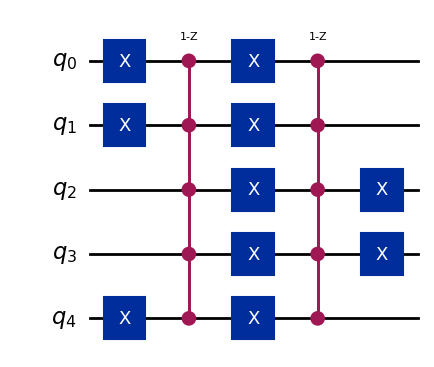

In [34]:
marked_states = ["01100", "10011"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

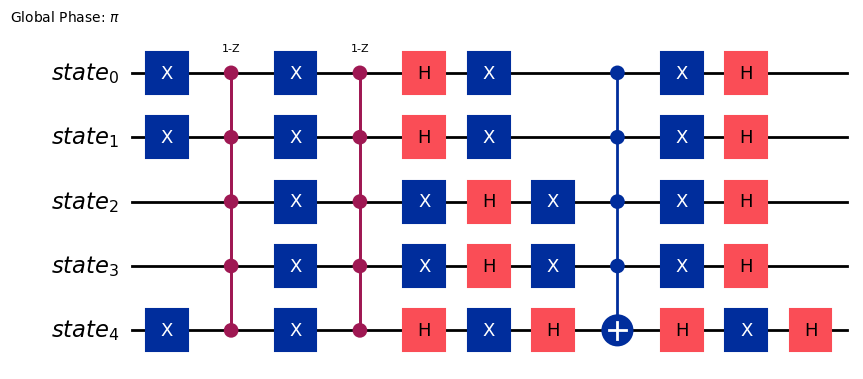

In [35]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

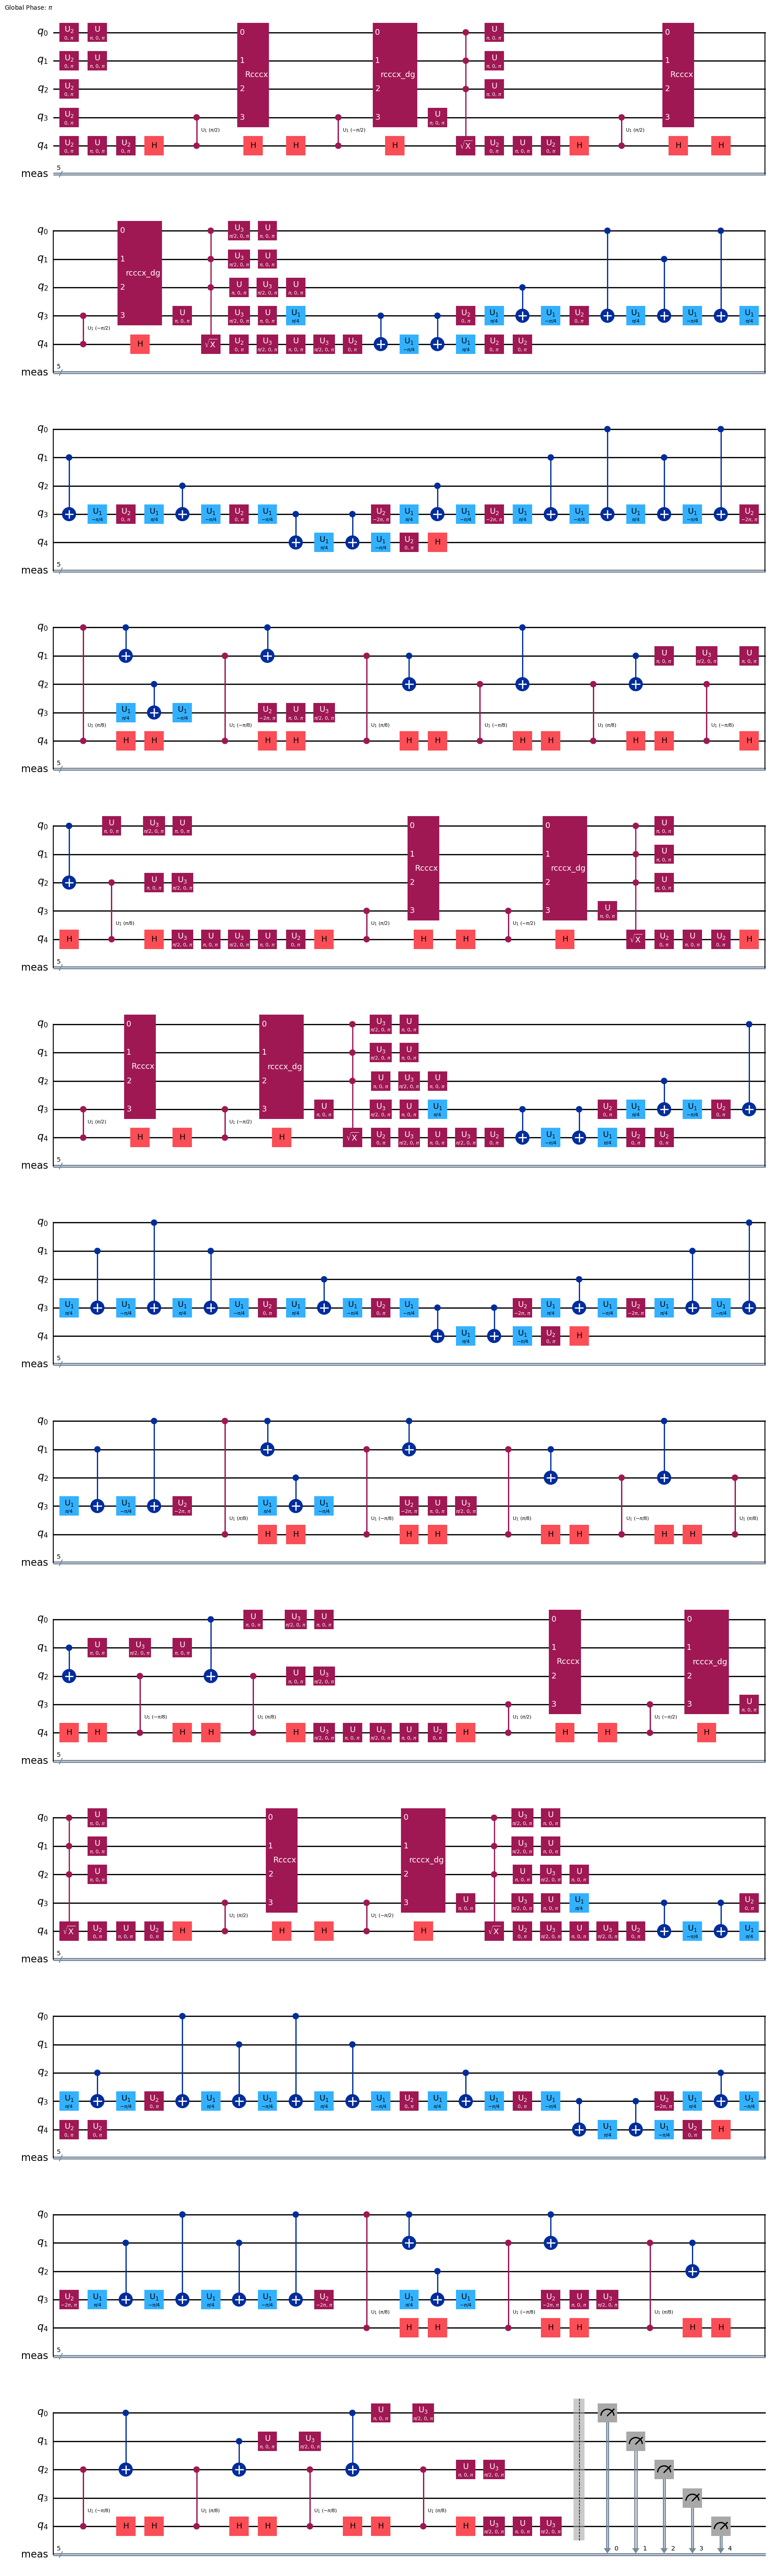

In [62]:
import math
grover_op = grover_op.decompose()
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")
qc.decompose().draw(output="mpl", style="iqp")

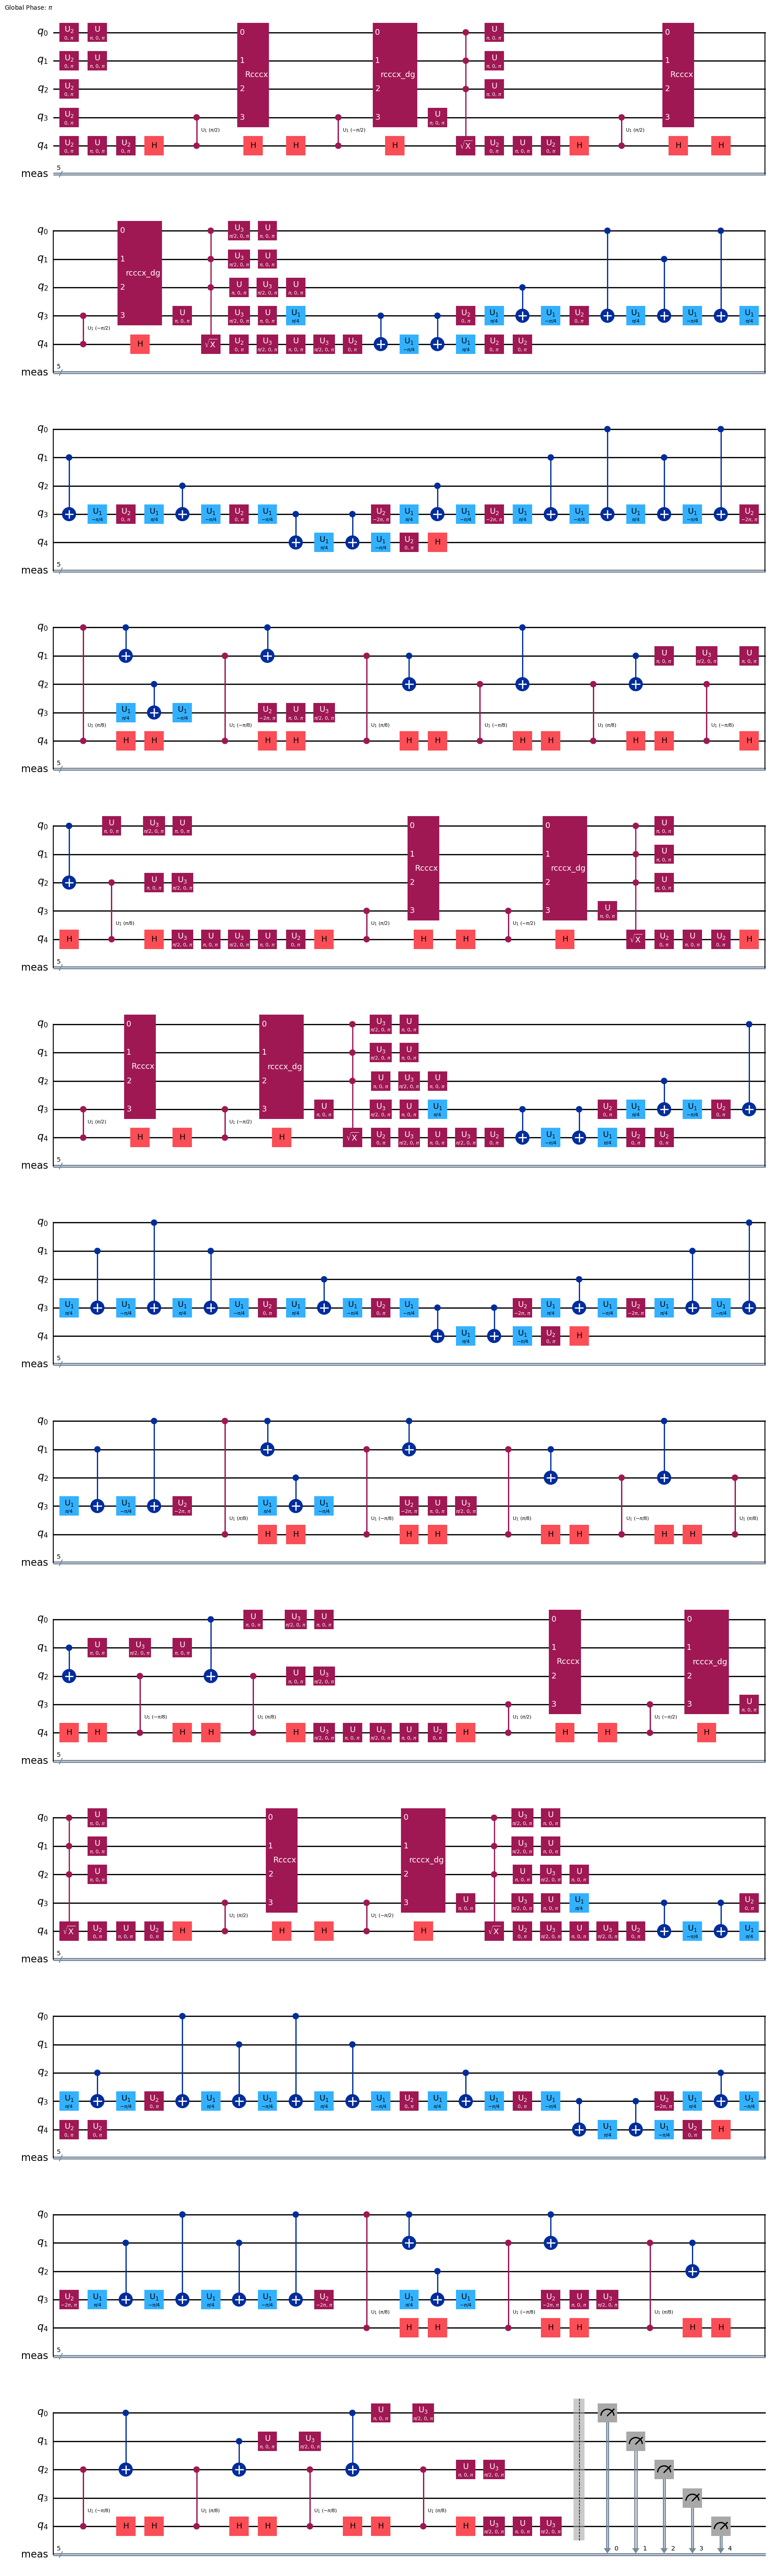

In [63]:
qc_decomposed = qc.decompose()
pass_manager = PassManager([XHXtoHZReduction()])
qc_decomposed = pass_manager.run(qc_decomposed)
qc_decomposed.draw(output="mpl", style="iqp")

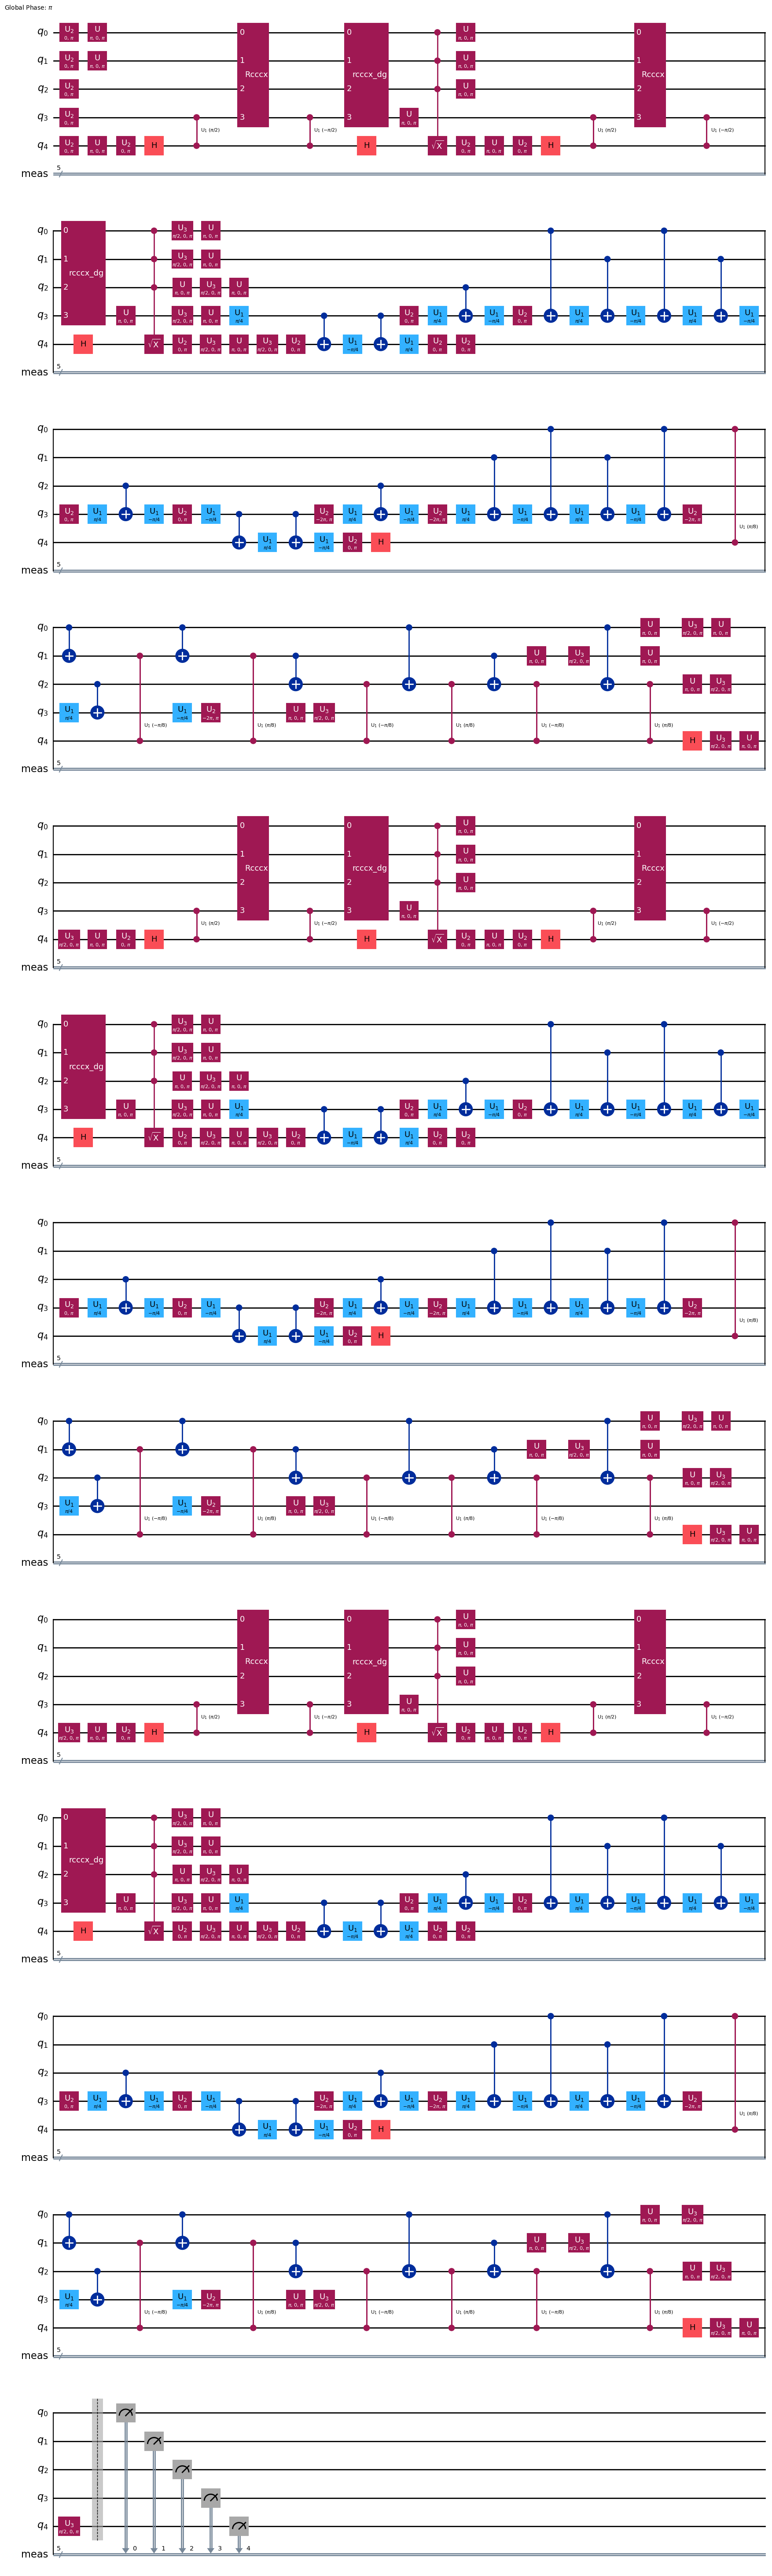

In [64]:
pass_manager = PassManager(RemoveConsecutiveH())
qc_decomposed = pass_manager.run(qc_decomposed)
qc_decomposed.draw(output="mpl", style="iqp")

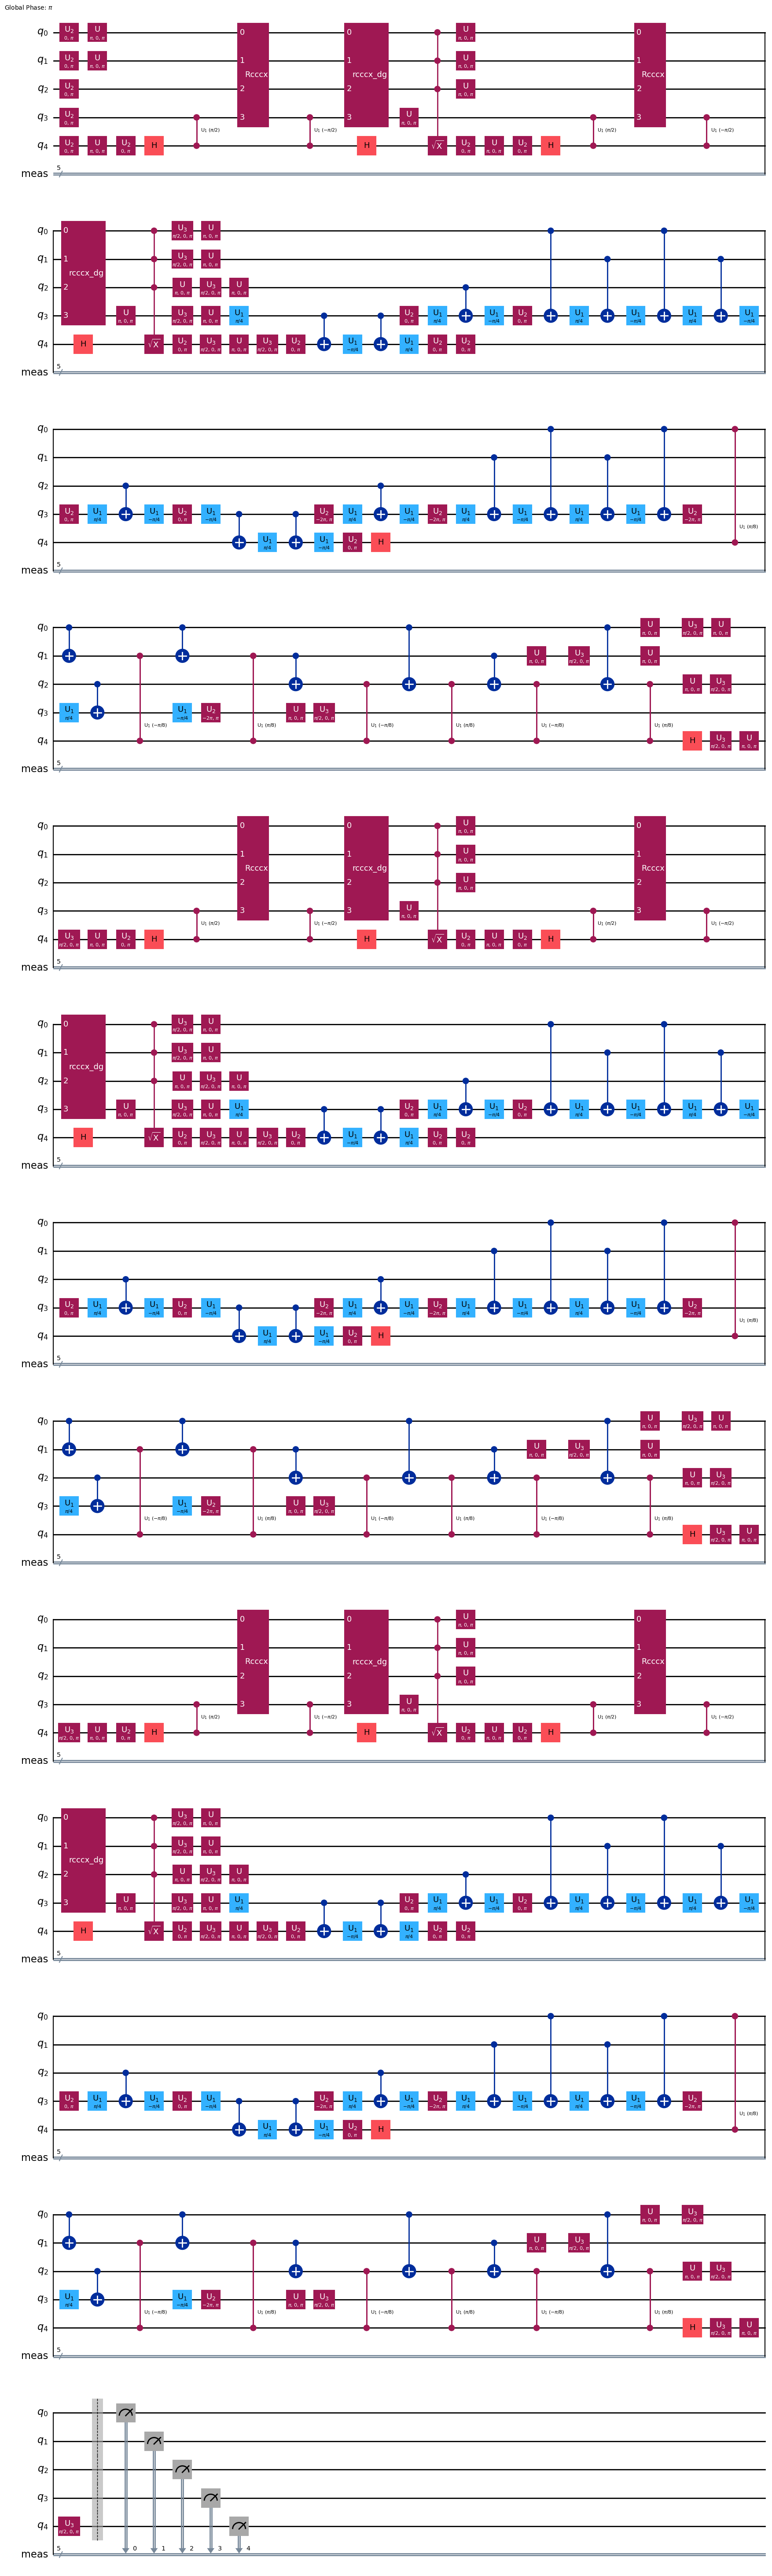

In [65]:
pass_manager = PassManager(HXHtoZReduction())
qc_decomposed = pass_manager.run(qc_decomposed)
qc_decomposed.draw(output="mpl", style="iqp")

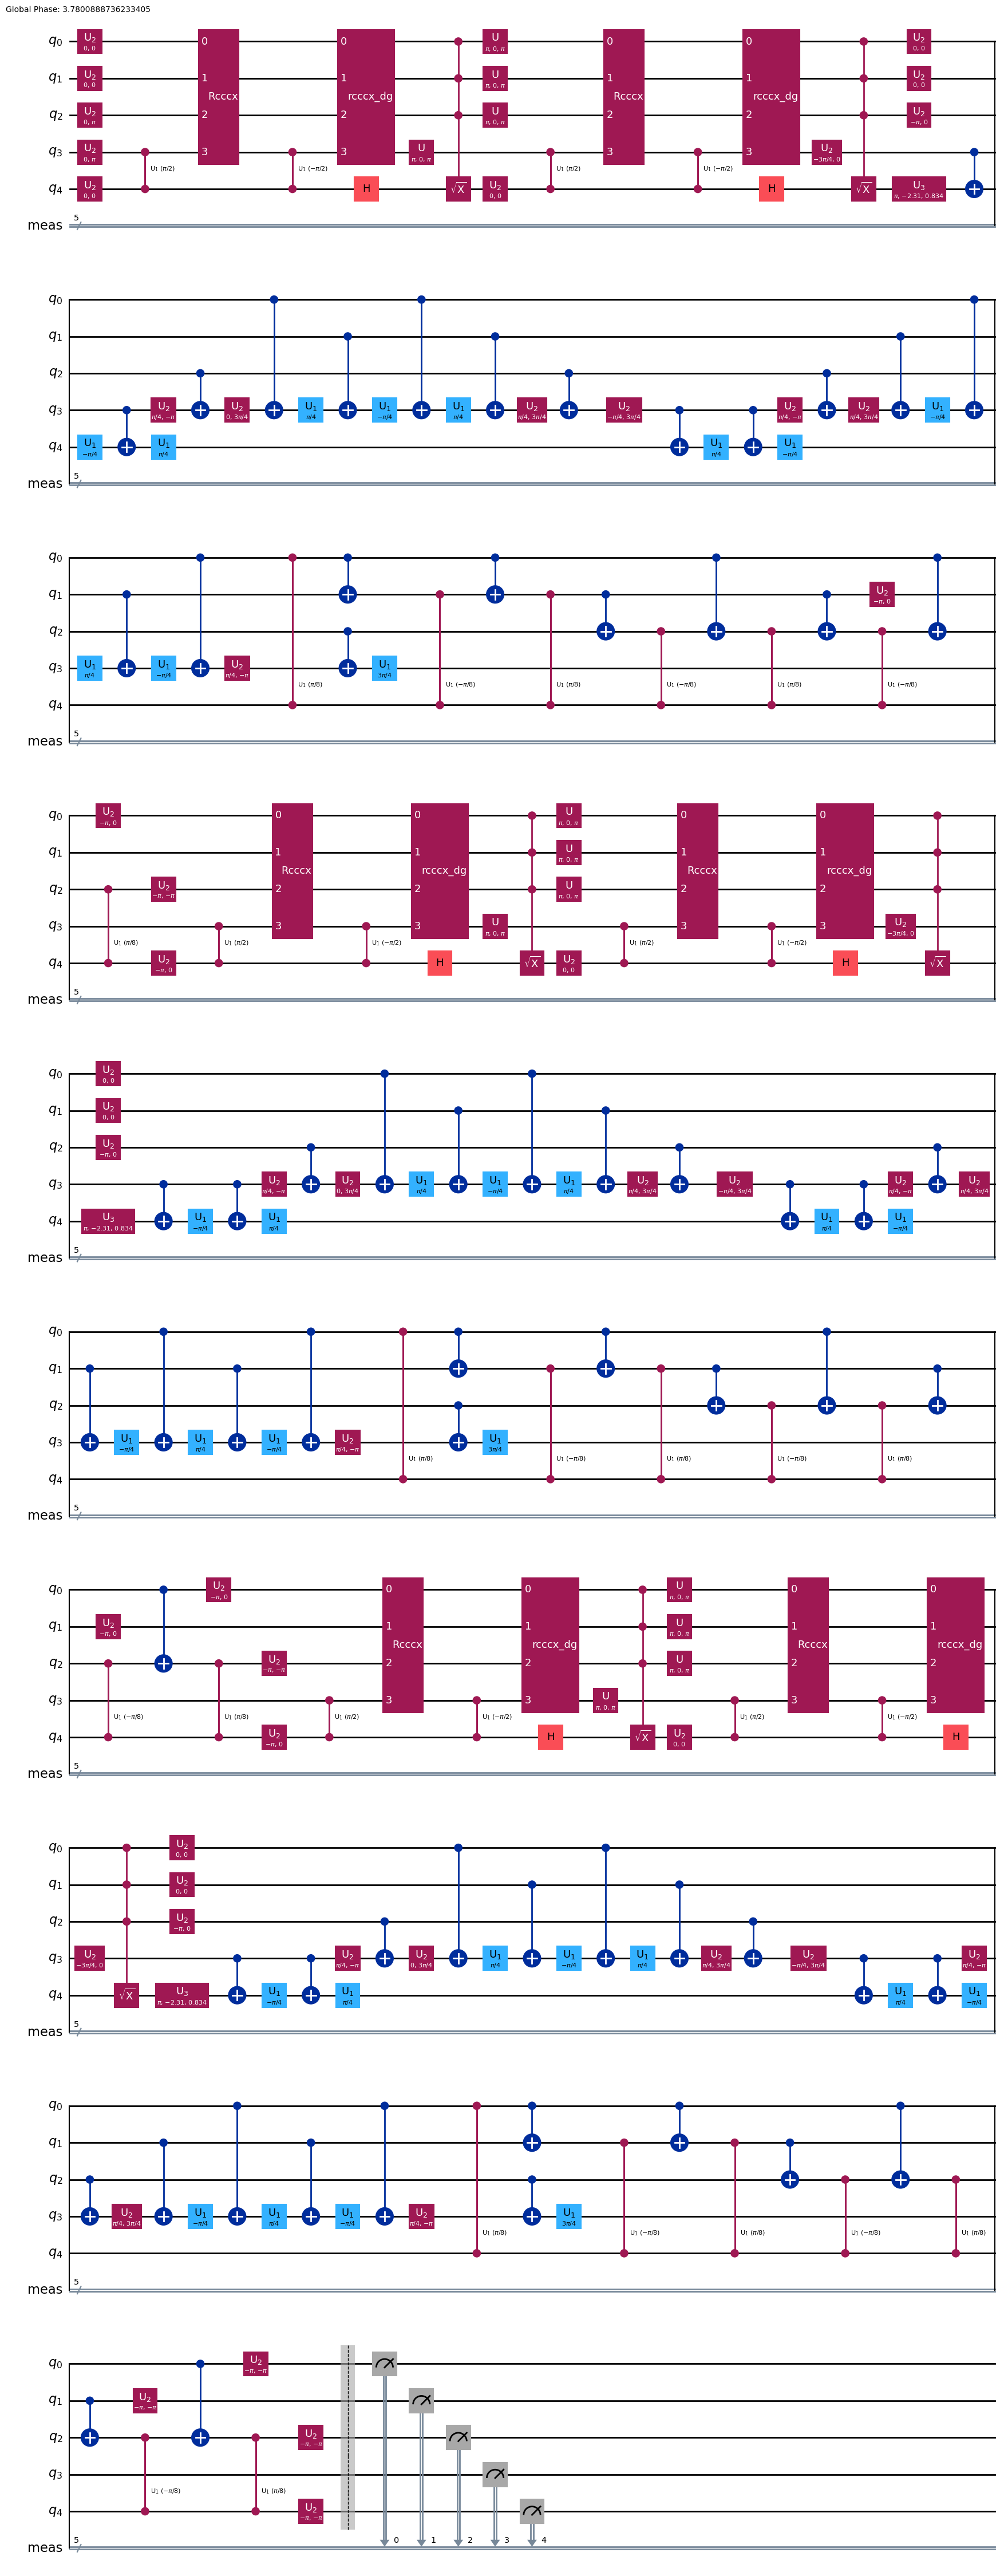

In [66]:
from qiskit.transpiler import CouplingMap

# Linear chain: 0-1-2-3-4
cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (2, 3), (3, 4)])
cmap.draw()

optimized_circuit = transpile(qc_decomposed, optimization_level=1)
optimized_circuit.draw(output="mpl", style="iqp")

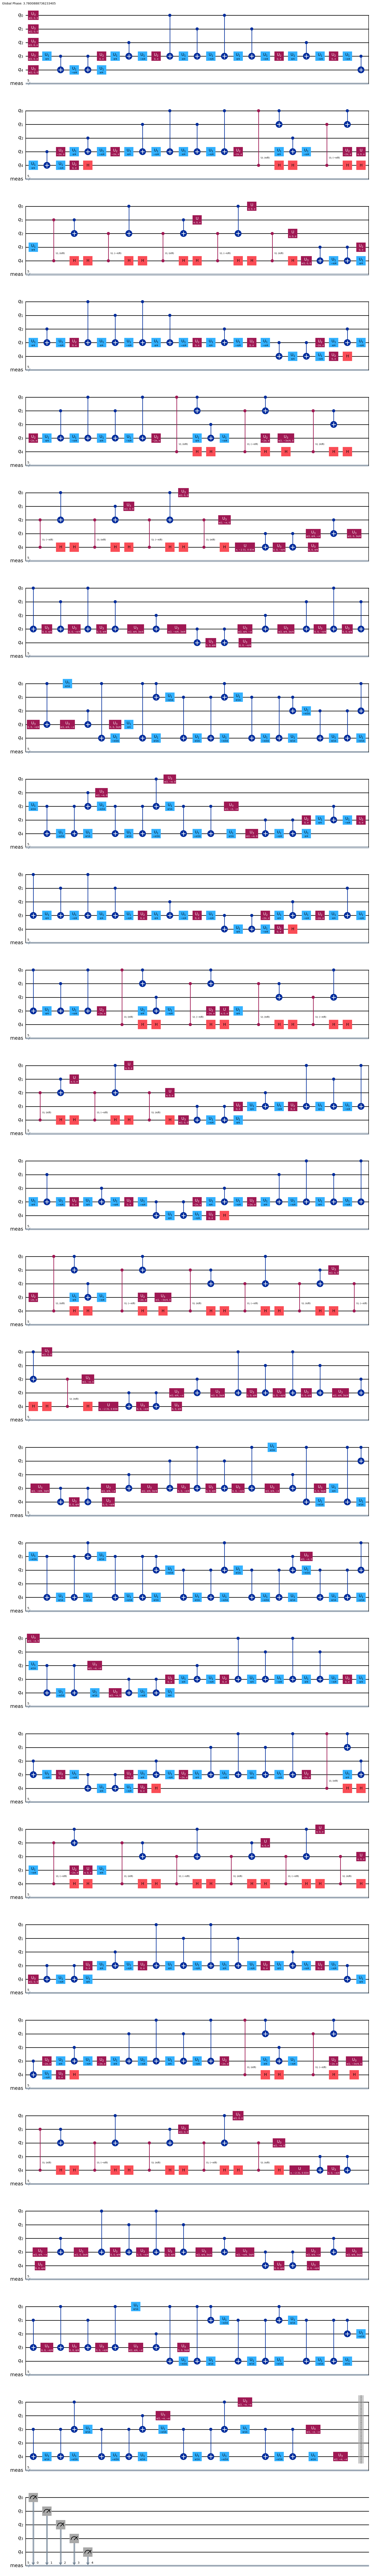

In [67]:
qc_final = optimized_circuit.decompose()

qc_final.draw(output="mpl", style="iqp")

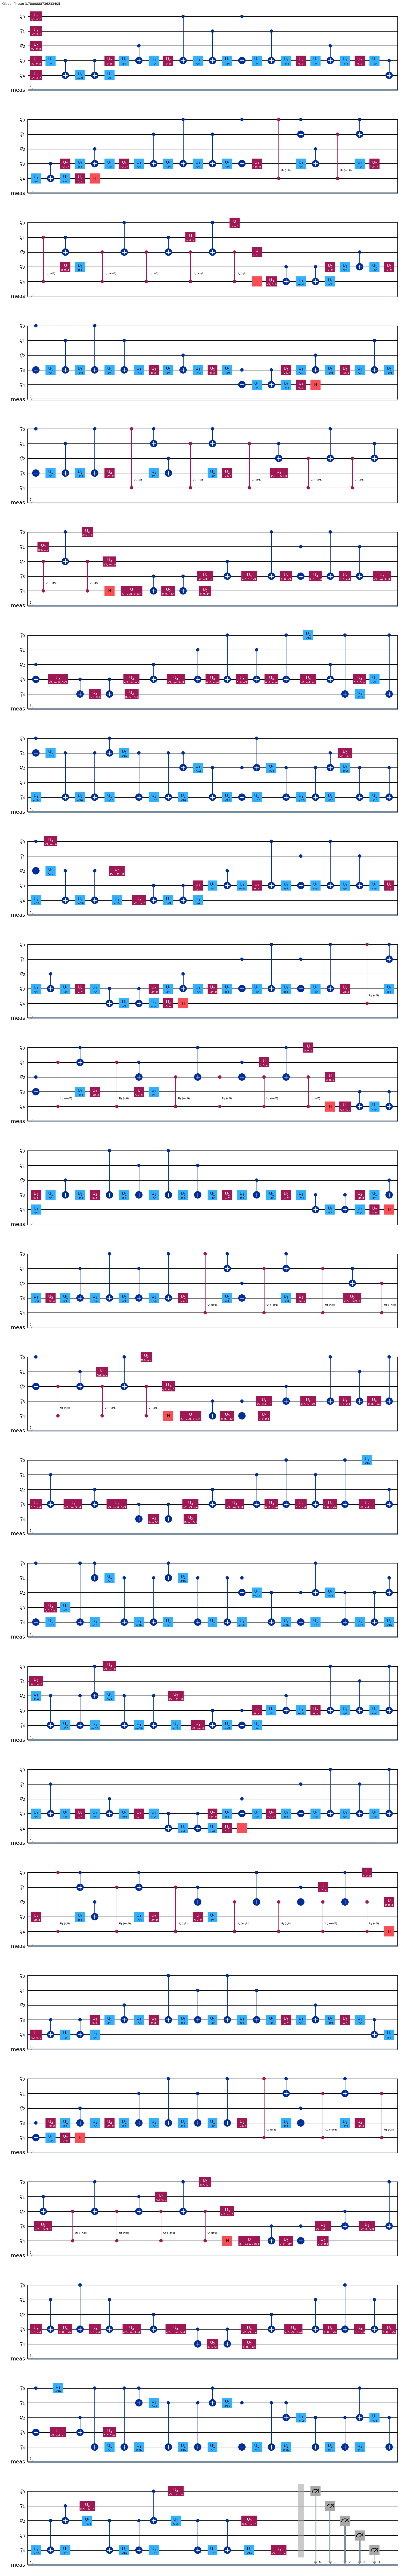

In [68]:
pass_manager = PassManager([XHXtoHZReduction(), RemoveConsecutiveH(), HXHtoZReduction(), MergeConsecutiveRX()])
optimized_circuit = pass_manager.run(qc_final)
optimized_circuit.draw(output="mpl", style="iqp")

In [69]:
print("Depth after qiskit's pass manager: ", qc_final.depth())
print("Depth after custom pass manager: ", optimized_circuit.depth())

Depth after qiskit's pass manager:  552
Depth after custom pass manager:  516


In [ ]:
print("original depth: ", transpile(qc.decompose(), optimization_level=0).decompose().depth())

original depth:  257
